['n03133878', 'n04357314', 'n02097209', 'n01855672']


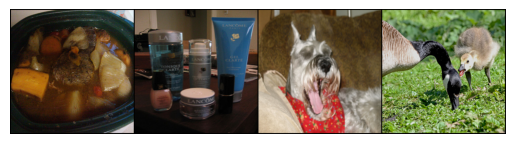

In [2]:
#!/usr/bin/env python3
# coding: utf-8

import sys 
sys.path.insert(0, '/home/lilly/miniconda3/lib/python3.10/site-packages')
import torch
import torchvision
from torch.utils.data import Dataset
import torchvision.transforms.functional as fn
import torchvision.transforms as T
import matplotlib.pyplot as plt
from utilities import createAnnotation
from model_loader import get_new_model
import pandas as pd
from IPython.display import display
from PIL import Image 
import random
import numpy as np
import tqdm as notebook_tqdm
import gradio as gr
from Dataset import *
import json
import class_katalog

In [3]:
# returns just its input
# needed for some outputs
def self(item):
    return item

In [4]:
#Here we configure the Datacollector, which contains all informations of once Usercall
def addUserId(UserId):
    dataCollector['UserId'] = UserId

def addBatchsize(batchsize):
    dataCollector['batchsize'] = int(batchsize)

def addImg(imgIds):
    assert dataCollector['batchsize'] == len(imgIds)
    Samples = []
    for i in range(dataCollector['batchsize']):
        Samples.append({'ImgId': imgIds[i], 'topTen': []})
    dataCollector['Imgs'] = Samples

def addTopTen(topTenList):
    assert len(topTenList) == len(dataCollector['Imgs'])
    for i in range(len(topTenList)):
        dataCollector['Imgs'][i]['topTen'] = topTenList[i]

def addDecesion(decesion):
    global decesions
    decesions.append(decesion)
    if len(decesions) == dataCollector['batchsize']:
        assert dataCollector['batchsize'] == len(dataCollector['Imgs'])
        for i in range(len(dataCollector['Imgs'])):
            dataCollector['Imgs'][i]['decesion'] = decesions[i]
        decesions = []
    
def addSource(sourceList):
    assert len(sourceList) == len(dataCollector['Imgs'])
    for i in range(len(dataCollector['Imgs'])):
        dataCollector['Imgs'][i]['source'] = sourceList[i]

def addLabel(labelList):
    assert len(labelList) == len(dataCollector['Imgs'])
    for i in range(len(dataCollector['Imgs'])):
        dataCollector['Imgs'][i]['label'] = labelList[i]

def addModel(model):
    dataCollector['model'] = model

#create an object for a Usercall, in case that we want to insert a new image into our database
def creatJsonObject(img):
    topTen = img['topTen']
    object = {
                'ImgID' : img['ImgId'],
                'source' : img['source'],
                'label': img['label'],
                'topTen': {dataCollector['model']: topTen},
                'UserCall': [
                    {
                        'userId' : dataCollector['UserId'],
                        'model' : dataCollector['model'],
                        'decesion': img['decesion']
                    }
                ]
            }

    return object

#update the Object of the image, which already exists in database.
def updateObject(img):
    for obj in data:
        if obj['source'] == img['source']:
            call = {
                'userId' : dataCollector['UserId'],
                'model' : dataCollector['model'],
                'decesion': img['decesion']
            }
            obj['UserCall'].append(call)
             #extend container of topTen if we call a new model for this image 
            key = dataCollector['model']
            if key not in obj['topTen']:
                obj['topTen'][key] = img['topTen']

#update our database ,everytime a Usercall happens
def updateData():
    for img in dataCollector['Imgs']:
        if img['source'] not in imgSet:
            obj = creatJsonObject(img)
            data.append(obj)
            imgSet.add(img['source'])
        else:
            updateObject(img)

In [5]:
# returns the labels per image which have to be evaluated and the indices of the images
def loadDataFromModel(batchSize):
    batch, batch3dim, indexList, sourceList, labelList = createRandomBatch(batchSize)
    global modelName
    modelName = "convnext_tiny"
    model = get_new_model(modelName, not_original=True)
    if modelName == "convnext_tiny":
        ckpt = torch.load('convnext_tiny_cvst_clean.pt', map_location='cpu')
        ckpt = {k.replace('module.', ''): v for k, v in ckpt.items()}
        model.load_state_dict(ckpt)
    samples = feedModel(batch) 
    topTenList = findLabels(samples, 10)
    labels = []
    # just for test purpose
    for i in range(0, batchSize):
        labels.append(topTenList[i])

    return labels, indexList, sourceList, topTenList, labelList



In [6]:
# generates the whole evaluation output
def generateEval(batchSize, uId):
    batchSize = int(batchSize)
    labels, indexList, sourceList, topTenList, labelList = loadDataFromModel(batchSize)
    addImg(indexList)
    addTopTen(topTenList)
    addModel(modelName)
    addSource(sourceList)
    addLabel(labelList)
    
    global bSize
    bSize = batchSize
    global iList
    iList = indexList
    global allLabels
    allLabels = labels
    global loop
    loop = 0

    displayEval()

In [7]:
# user selected IID
def selectIid():#userId, iList, allL, bSize, loop):
  # update json
    addDecesion('IID')
  # display next eval  
    global loop
    global batchSize
    if loop < (bSize-1):
        loop = loop + 1
        displayEval()
    else: endEval()

# user selected OOD    
def selectOod():
  # update json
    addDecesion('OOD')
  # display next eval  
    global loop
    global batchSize
    if loop < (bSize-1):
        loop = loop + 1
        displayEval()
    else: endEval()

# user selected abstinent
def selectAbstinent():
  # update json
    addDecesion('Abstinent')
  # display next eval
    global loop
    global batchSize
    if loop < (bSize-1):
        loop = loop + 1
        displayEval()
    else: endEval()

# shows an image, the labels and three buttons
def displayEval():#indexList, allLabels, uId, batchSize, loop, labelList):
    global loop
    global iList
    global allLabels
    imgPath = imageDataset.__getitem__(iList[loop])[0]
    labels = allLabels[loop]
    with gr.Blocks() as demo:
        gr.Markdown('''Please decide if the image is in 'independent identically distribution' (IID) or 'out of distribution' (OOD) related to the predicted labels of the model.
        If your are not sure choose 'abstinent'. ''')
        fn = self
        inputs = gr.Image(imgPath).style(height=350)
        outputs = None
        gr.Markdown('''The top labels predicted by the model:''')
        gr.Markdown(f'''{labels}''')
        with gr.Row():
            iidBtn = gr.Button("IID")
            oodBtn = gr.Button("OOD")
            abstinentBtn = gr.Button("abstinent")
        iidBtn.click(fn=selectIid, inputs=None, outputs=None, api_name="IID")
        oodBtn.click(fn=selectOod, inputs=None, outputs=None, api_name="OOD")
        abstinentBtn.click(fn=selectAbstinent, inputs=None, outputs=None, api_name="abstinent")
    
    demo.launch()

In [8]:
# first checks if userId exists
# if not: redirects the user back to sing-in
# if yes: asks for the amount of images the user want to evaluate 
def askAmount(uId):
    uIdExists = False
    for obj in emails_ids:
        if obj['userId'] == uId:
            uIdExists = True
    if uIdExists == False:
        with gr.Blocks() as demo:
            gr.Markdown('''This userId isn´t registered. Please reconsider your input or sign in with your e-mail address.''')
            backToSignInBtn = gr.Button("Back to sign in")
            backToSignInBtn.click(fn=generateSignIn, inputs=None, outputs=None, api_name="Back to sign in") 
            
        demo.launch()
    else:        
        with gr.Blocks() as demo:
            batchSize = gr.Textbox(label="Please enter the amount of images you want to evaluate:", placeholder="positive number")
            batchSizeDefault = gr.Textbox(visible = False, value=15)
            userId = gr.Textbox(visible = False, value=uId)

            with gr.Row():
                startBtn = gr.Button("Start")
                defaultBtn = gr.Button("evaluate 15 images")

            startBtn.click(fn=generateEval, inputs = [batchSize, userId], outputs=None)#, api_name="Start")
            # add Batchsize to datacollector
            startBtn.click(fn=addBatchsize, inputs = batchSize, outputs=None)#, api_name="Start")
            
            defaultBtn.click(fn=generateEval, inputs = [batchSizeDefault, userId], outputs=None)
            defaultBtn.click(fn=addBatchsize, inputs = batchSizeDefault, outputs=None)
        
        demo.launch()

In [9]:
# Example to show the datastructur of dataCollector:
# {
#     'UserId' : 01,
#     'model' : 'modelname',
#     'batchsize' : 2,
#     'Imgs' : [
#         {'ImgId': 1,
#          'label': n0xxxxxxxx,
#          'source': '/path1',
#          'topTen': [0,1,2,3,4,5,6,7,8,9],
#          'decesion': 'OOD'}
#          ,
#          {'ImgId': 2,
#           'label': n0xxxxxxxx,
#           'source': '/path2',
#           'topTen': [0,1,2,3,4,5,6,7,8,9],
#           'decesion': 'ID'}
#     ]
# }
# 
# After a user decide a batch of images, we get all the informations of this time decision as a dict,
# but this dict is not yet directly an object that we can save in our database. 
# So we need to firstly convert it to the form of expected datastructer of object, and then convert it to .json format.

In [10]:
# generates a new userId and updates the emails dict
def generateId(mail):
    if (len(emails_ids) == 0):
        newId = 1000
    else:
        maxId = 1000
        for obj in emails_ids:
            if obj['userId'] > maxId:
                maxId = obj['userId']
        newId = maxId + 1
    dictIn = {
        'email': mail,
        'userId': newId
    }
    emails_ids.append(dictIn)
    databasePath = 'emails_ids.json'
    # write email and new Id into json file
    with open(databasePath, 'w') as database:
        json.dump(emails_ids, database, indent=4)
    return newId
        
# checks if the participant already owns a userId
# if not: a userId gets generated
def checkMail(mail):
    alreadyId = False
    for obj in emails_ids:
        if obj['email'] == mail:
            uId = obj['userId']
            with gr.Blocks() as demo:
                gr.Markdown(f'''
                You already have an userId. Keep it in mind: {uId}
                ''')
                gr.Markdown('''Please sign in again!''')
                backToSignInBtn = gr.Button("Back to sign in")
                backToSignInBtn.click(fn=generateSignIn, inputs=None, outputs=None, api_name="Back to sign in")
                
            demo.launch()
            alreadyId = True
            break
            
    if alreadyId == False:
        newId = generateId(mail)
        with gr.Blocks() as demo:
            gr.Markdown(f'''
            That´s your personal userId which is just generated for your sign-in: {newId}
            ''')
            gr.Markdown('''Please keep it in mind and sign in again!''')
            backToSignInBtn = gr.Button("Back to sign in")
            backToSignInBtn.click(fn=generateSignIn, inputs=None, outputs=None, api_name="Back to sign in")
        
        demo.launch()
        
# handles the sign-in-input
# checks whether the potentially given email already has an userId or not
def handleFirstIn(idOrMail):
    try: 
        int(idOrMail)
    except:
        checkMail(idOrMail)
    else: 
        #add User id to datacollector
        addUserId(int(idOrMail))
        askAmount(int(idOrMail)) 

# generates the sign-in page 
def generateSignIn():
    with gr.Blocks() as demo:
        idOrMail = gr.Textbox(label="Please enter your UserID or, in case you don´t have one yet, please enter your e-mail address:", placeholder="UserID or e-mail")
        signInBtn = gr.Button("Sign in")
        signInBtn.click(fn=handleFirstIn, inputs=idOrMail, outputs=None, api_name="Sign in")

    demo.launch()


In [11]:
# load existing emails and Id´s from database
with open('emails_ids.json') as file:
    json_str = file.read()

emails_ids = json.loads(json_str)

# load existing data from database
with open('data.json') as file:
    json_str = file.read()

data = json.loads(json_str)

#load the Set of all images in database, so that we can decide if a new image already exists in database. 
imgSet = set()
if len(data) > 0:
    for obj in data:
        imgSet.add(obj['source'])

#initialize temporary data container: dataCollector and decesions
dataCollector = dict()
decesions = []

In [12]:
def endEval():
    #add the new genarated data into database(here as dict)
    updateData()

    databasePath = 'data.json'
    # write data into json file
    with open(databasePath, 'w') as database:
        json.dump(data, database, indent=4)

    #empty the container
    dataCollector = dict()
    decesions = []
    
    sys.exit(0)

In [13]:
generateSignIn()

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.


Running on local URL:  http://127.0.0.1:7863

To create a public link, set `share=True` in `launch()`.


Traceback (most recent call last):
  File "/home/lilly/miniconda3/lib/python3.10/site-packages/gradio/routes.py", line 422, in run_predict
    output = await app.get_blocks().process_api(
  File "/home/lilly/miniconda3/lib/python3.10/site-packages/gradio/blocks.py", line 1323, in process_api
    result = await self.call_function(
  File "/home/lilly/miniconda3/lib/python3.10/site-packages/gradio/blocks.py", line 1051, in call_function
    prediction = await anyio.to_thread.run_sync(
  File "/home/lilly/miniconda3/lib/python3.10/site-packages/anyio/to_thread.py", line 31, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(
  File "/home/lilly/miniconda3/lib/python3.10/site-packages/anyio/_backends/_asyncio.py", line 937, in run_sync_in_worker_thread
    return await future
  File "/home/lilly/miniconda3/lib/python3.10/site-packages/anyio/_backends/_asyncio.py", line 867, in run
    result = context.run(func, *args)
  File "/tmp/ipykernel_1959/142651113.py", line 35, i

In [13]:
#add the new genarated data into database(here as dict)
updateData()

databasePath = 'data.json'
# write data into json file
with open(databasePath, 'w') as database:
    json.dump(data, database, indent=4)

#empty the container
dataCollector = dict()
decesions = []